In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt
mixed_precision.set_global_policy('mixed_float16')

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/train'
test_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/test'
val_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/val'

Mounted at /content/drive


In [3]:
print(train_dir)
print(test_dir)
print(val_dir)
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 16

/content/drive/MyDrive/Pneumonia Disease/dataset/train
/content/drive/MyDrive/Pneumonia Disease/dataset/test
/content/drive/MyDrive/Pneumonia Disease/dataset/val


In [6]:
def load_dataset(directory):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=True
    )
    return generator  # Return generator instead of full dataset in memory

# Use generator directly in training (faster)
train_gen = load_dataset(train_dir)
test_gen = load_dataset(test_dir)
val_gen = load_dataset(val_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
# import os
# print(os.listdir('/content/drive/MyDrive/Pneumonia Disease/'))  # Check the base folder
# print(os.listdir('/content/drive/MyDrive/Pneumonia Disease/dataset/'))  # Check the dataset folder
# print(os.listdir('/content/drive/MyDrive/Pneumonia Disease/dataset/train'))  # Check the train folder

In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_indices = train_gen.class_indices  # Dictionary {class_name: index}
class_counts = train_gen.classes  # Class labels for each image in train dataset

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_counts),
    y=class_counts
)

# Convert to dictionary format for model.fit()
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [11]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
for layer in vgg.layers:
  layer.trainable = False

In [13]:
folders = glob('/content/drive/MyDrive/Pneumonia Disease/dataset/train/*')
print(len(folders))

2


In [14]:
x = GlobalAveragePooling2D()(vgg.output)  # Replaces Flatten()
x = Dense(128, activation='relu')(x)  # Reduce parameters
prediction = Dense(1, activation='sigmoid')(x)  # Binary classification


In [15]:
# prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [18]:
# Initialize ImageDataGenerator for normalization and augementation
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normlize images to [0,1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# val_datagen = ImageDataGenerator(rescale=1./255) # only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255) # only rescaling for test


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
)

# val_gen = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=(224, 224),
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     shuffle=False
# )

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    # shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

r = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,  # Train longer
    steps_per_epoch=100,
    validation_steps=50,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler]  # Adjust learning rate dynamically
)


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 467ms/step - accuracy: 0.8923 - loss: 0.2846 - val_accuracy: 0.8333 - val_loss: 0.3944 - learning_rate: 1.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 470ms/step - accuracy: 0.8966 - loss: 0.2595 - val_accuracy: 0.8494 - val_loss: 0.3712 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 452ms/step - accuracy: 0.9052 - loss: 0.2630 - val_accuracy: 0.8397 - val_loss: 0.3769 - learning_rate: 1.0000e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.8819 - loss: 0.2774 - val_accuracy: 0.8478 - val_loss: 0.3633 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.9021 - loss: 0.2642 - val_accuracy: 0.8558 - val_loss: 0.3546 - learning_rate: 1.0000e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 470ms/step - accuracy: 0.8679 - loss: 0.3336 - val_accuracy: 0.8429 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 44

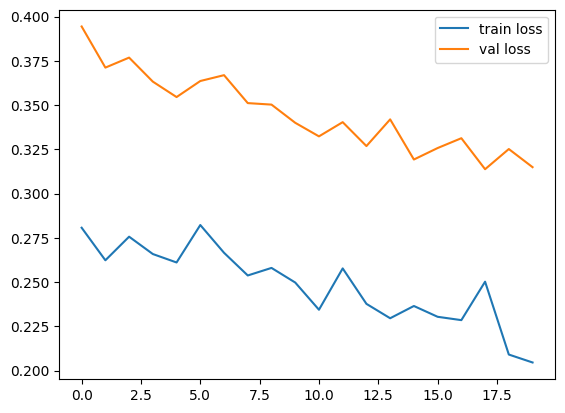

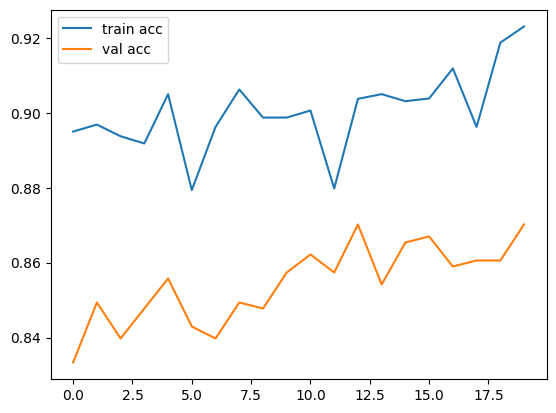

<Figure size 640x480 with 0 Axes>

In [25]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [32]:
# save it as a h5 file

import tensorflow as tf

from keras.models import load_model

# model.save('model_vgg16.h5')
model.save('/content/drive/My Drive/Pneumonia Disease/model_vgg16.h5')

In [27]:
# import matplotlib.pyplot as plt
# imgs, labels = next(train_gen)

# fig, axes = plt.subplots(1, 5, figsize=(10,10))
# for i in range(5):
#   ax = axes[i]
#   ax.imshow(imgs[i])
#   ax.set_title("Label: " + ("Normal" if labels[i] == 0 else "Pneumonia"))
#   ax.axis('off')
# plt.show()

In [28]:
# print("Number of images in train set: ", train_gen.samples)
# print("Number of images in test set: ", test_gen.samples)
# print("Number of images in validation set: ", val_gen.samples)

In [29]:
# train_normal_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/train/normal'
# test_normal_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/test/normal'
# val_normal_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/val/normal'
# train_opacity_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/train/opacity'
# test_opacity_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/test/opacity'
# val_opacity_dir = '/content/drive/MyDrive/Pneumonia Disease/dataset/val/opacity'

# def count_images(directory):
#   return([n for n in os.listdir(directory) if n.endswith(('.jpg', '.jpeg', '.png'))])

# train_normal_img = count_images(train_normal_dir)
# test_normal_img = count_images(test_normal_dir)
# val_normal_img = count_images(val_normal_dir)
# train_opacity_img = count_images(train_opacity_dir)
# test_opacity_img = count_images(test_opacity_dir)
# val_opacity_img = count_images(val_opacity_dir)

# print(f"Train Normal images: {len(train_normal_img)}")
# print(f"Train Opacity images: {len(train_opacity_img)}")
# print(f"Validation Normal images: {len(val_normal_img)}")
# print(f"Validation Opacity images: {len(val_opacity_img)}")
# print(f"Test Normal images: {len(test_normal_img)}")
# print(f"Test Opacity images: {len(test_opacity_img)}")

In [31]:
from google.colab import files
files.download('/content/drive/My Drive/model_vgg16.h5')


FileNotFoundError: Cannot find file: /content/drive/My Drive/model_vgg16.h5